# 7.8 Практическая работа

Выполните следующие шаги:

1. Обдумайте цель вашего проекта, распишите её в начале блокнота.
2. Импортируйте все необходимые библиотеки.
3. Соберите все необходимые фото и видео. Обязательно должны быть фото или видео, на которых нет целевого объекта.
4. Загрузите все примеры в сервис Roboflow или аналогичный, выполните разметку и аугментацию. Аугментацию можете выполнить отдельно через код.
5. В блокноте обучите выбранную вами модель (модели). Для более качественного обучения используйте GPU.
6. Интерпретируйте графики функции ошибок и метрик, полученные по итогам обучения модели.
7. На основе лучшей модели создайте веб-сервис с возможностью загрузки фотографии для детекции (аналогично уроку 7). Обдумайте, какой уровень уверенности при детекции вам нужен.
8. Сделайте выводы:
Насколько адекватно функционирует ваша модель?
Есть ли дисбаланс в данных?

### Вводные данные, цель и задачи практической работы

Пояснения
* Выбор задачи: Я выбрал детекцию моей кошки как домашнего животного. Для информации ее кличка "Катангенс", чтобы это не вводило в заблуждение в метках или если будет встречаться в коде).
* Цель: цель — детекция моей кошки с использованием YOLOv8, transfer learning и веб-сервиса. Указаны ожидаемые метрики (mAP > 0.75) для оценки качества.
* Подход: Использование заморозки 10 слоев и transfer learning, ожидается, что позволит ускорить обучение и улучшить результаты за счёт предобученных весов.

### 2. Загрузка библиотек

In [1]:
import os
import pandas as pd
import glob
import shutil
import xml.etree.ElementTree as ET


In [2]:
!pip install torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.4/838.4 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 117.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1

Код отказывается корректно работать, в связи с изменением вызова процедуры обучения модели c версии torch 2.6, поэтому было решено пинудительно использовать более старую версию, чтобы не терять время на изучениие нового синтаксиса и структуры вызова.

In [3]:
!pip install ultralytics==8.0.196

# display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.11.12 torch-2.5.1+cu118 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 45.3/112.6 GB disk)


In [4]:
from ultralytics import YOLO
from IPython.display import display, Image

### 4. Подключение датасета из Roboflow

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="v1Z3cR3tV8wyGh4zulTm")
project = rf.workspace("project-3iyqp").project("my-cat-project")
version = project.version(1)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-Cat-Project-1 in yolov8:: 100%|██████████| 126/126 [00:00<00:00, 8814.94it/s]


In [6]:
import os
os.chdir('/content/My-Cat-Project-1')

In [7]:
%cd /content/My-Cat-Project-1

/content


### 5. Загрузка, обучение модели YOLOv8 mini без заморозки слоев

In [8]:
# Загрузка модели YOLOv8 mini
model = YOLO("yolov8m.pt")

# Обучение на подготовленном датасете
results = model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="my_cat_model",
    pretrained=False,
    augment=True,  # Включаем аугментации пробно
    hsv_h=0.015,   # Изменение оттенка (hue) в диапазоне [0, 0.5]
    hsv_s=0.7,     # Изменение насыщенности (saturation) в диапазоне [0, 1]
    hsv_v=0.4,     # Изменение яркости (value) в диапазоне [0, 1]
    degrees=30.0,  # Максимальный угол поворота в градусах
    translate=0.1, # Перемещение (горизонтальное и вертикальное) в долях от размера изображения
    scale=0.5,     # Масштабирование в диапазоне [1-scale, 1+scale]
    shear=0.0,     # Скручивание (shear) в градусах, установлено 0 для простоты
    flipud=0.0,    # Вертикальное отражение (0.0 - отключено, 0.5 - 50% вероятность)
    fliplr=0.5,    # Горизонтальное отражение (0.5 - 50% вероятность)
    mosaic=1.0
)

100%|██████████| 49.7M/49.7M [00:00<00:00, 117MB/s]
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
New https://pypi.org/project/ultralytics/8.3.149 available 😃 Update with 'pip install -U ult

In [9]:
from IPython.display import Image as Display

### 6. Визуализация метрик результатов обучения

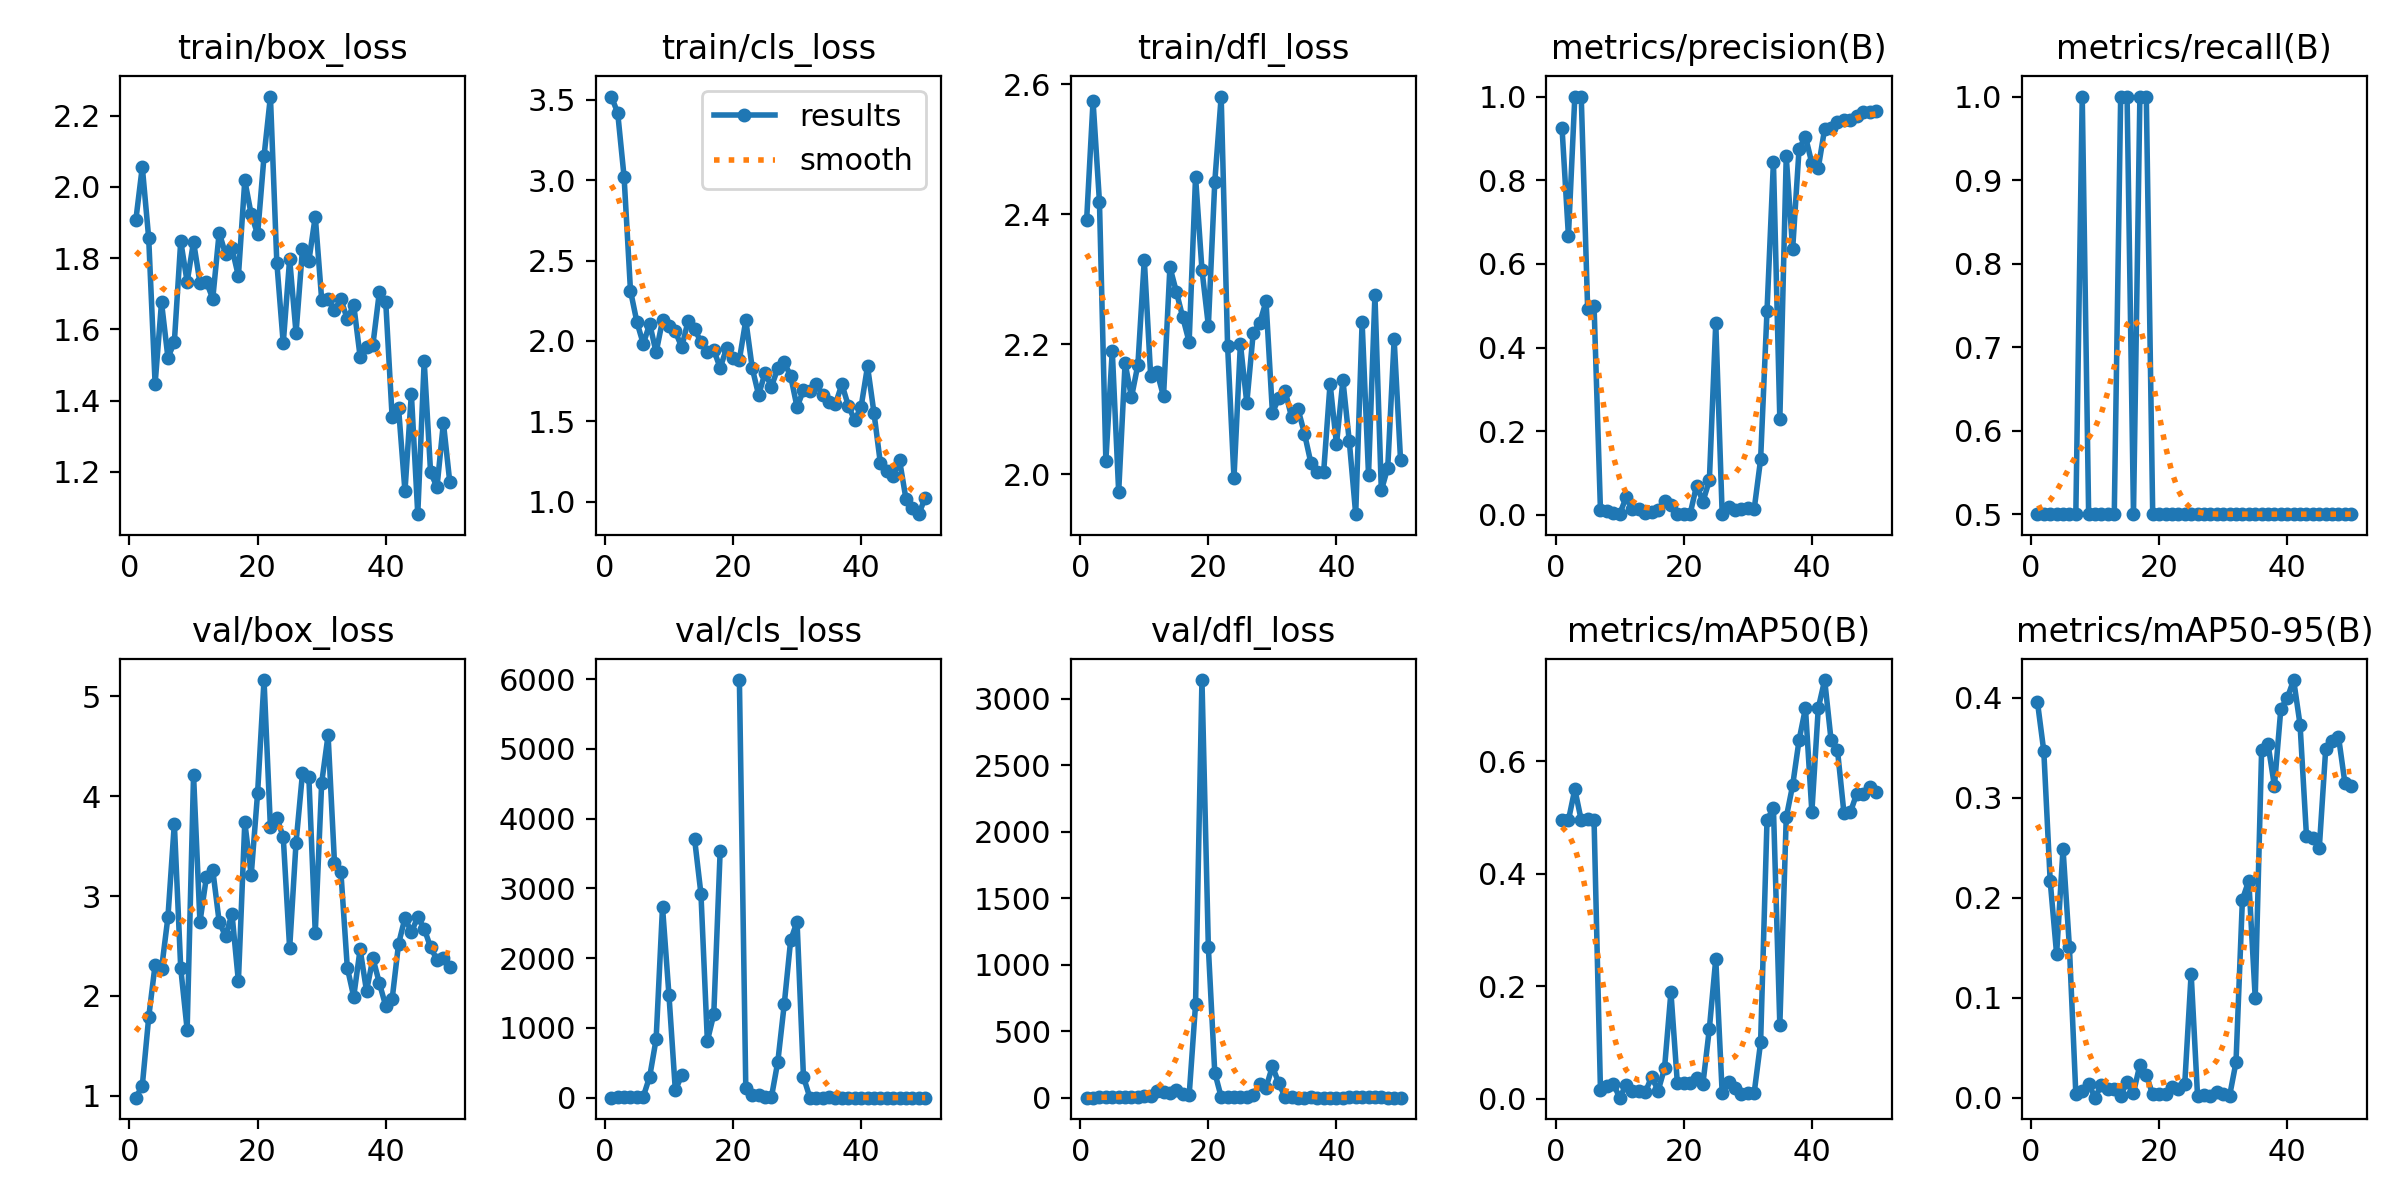

In [10]:
Display(filename='/content/My-Cat-Project-1/runs/detect/my_cat_model/results.png', width=1080)

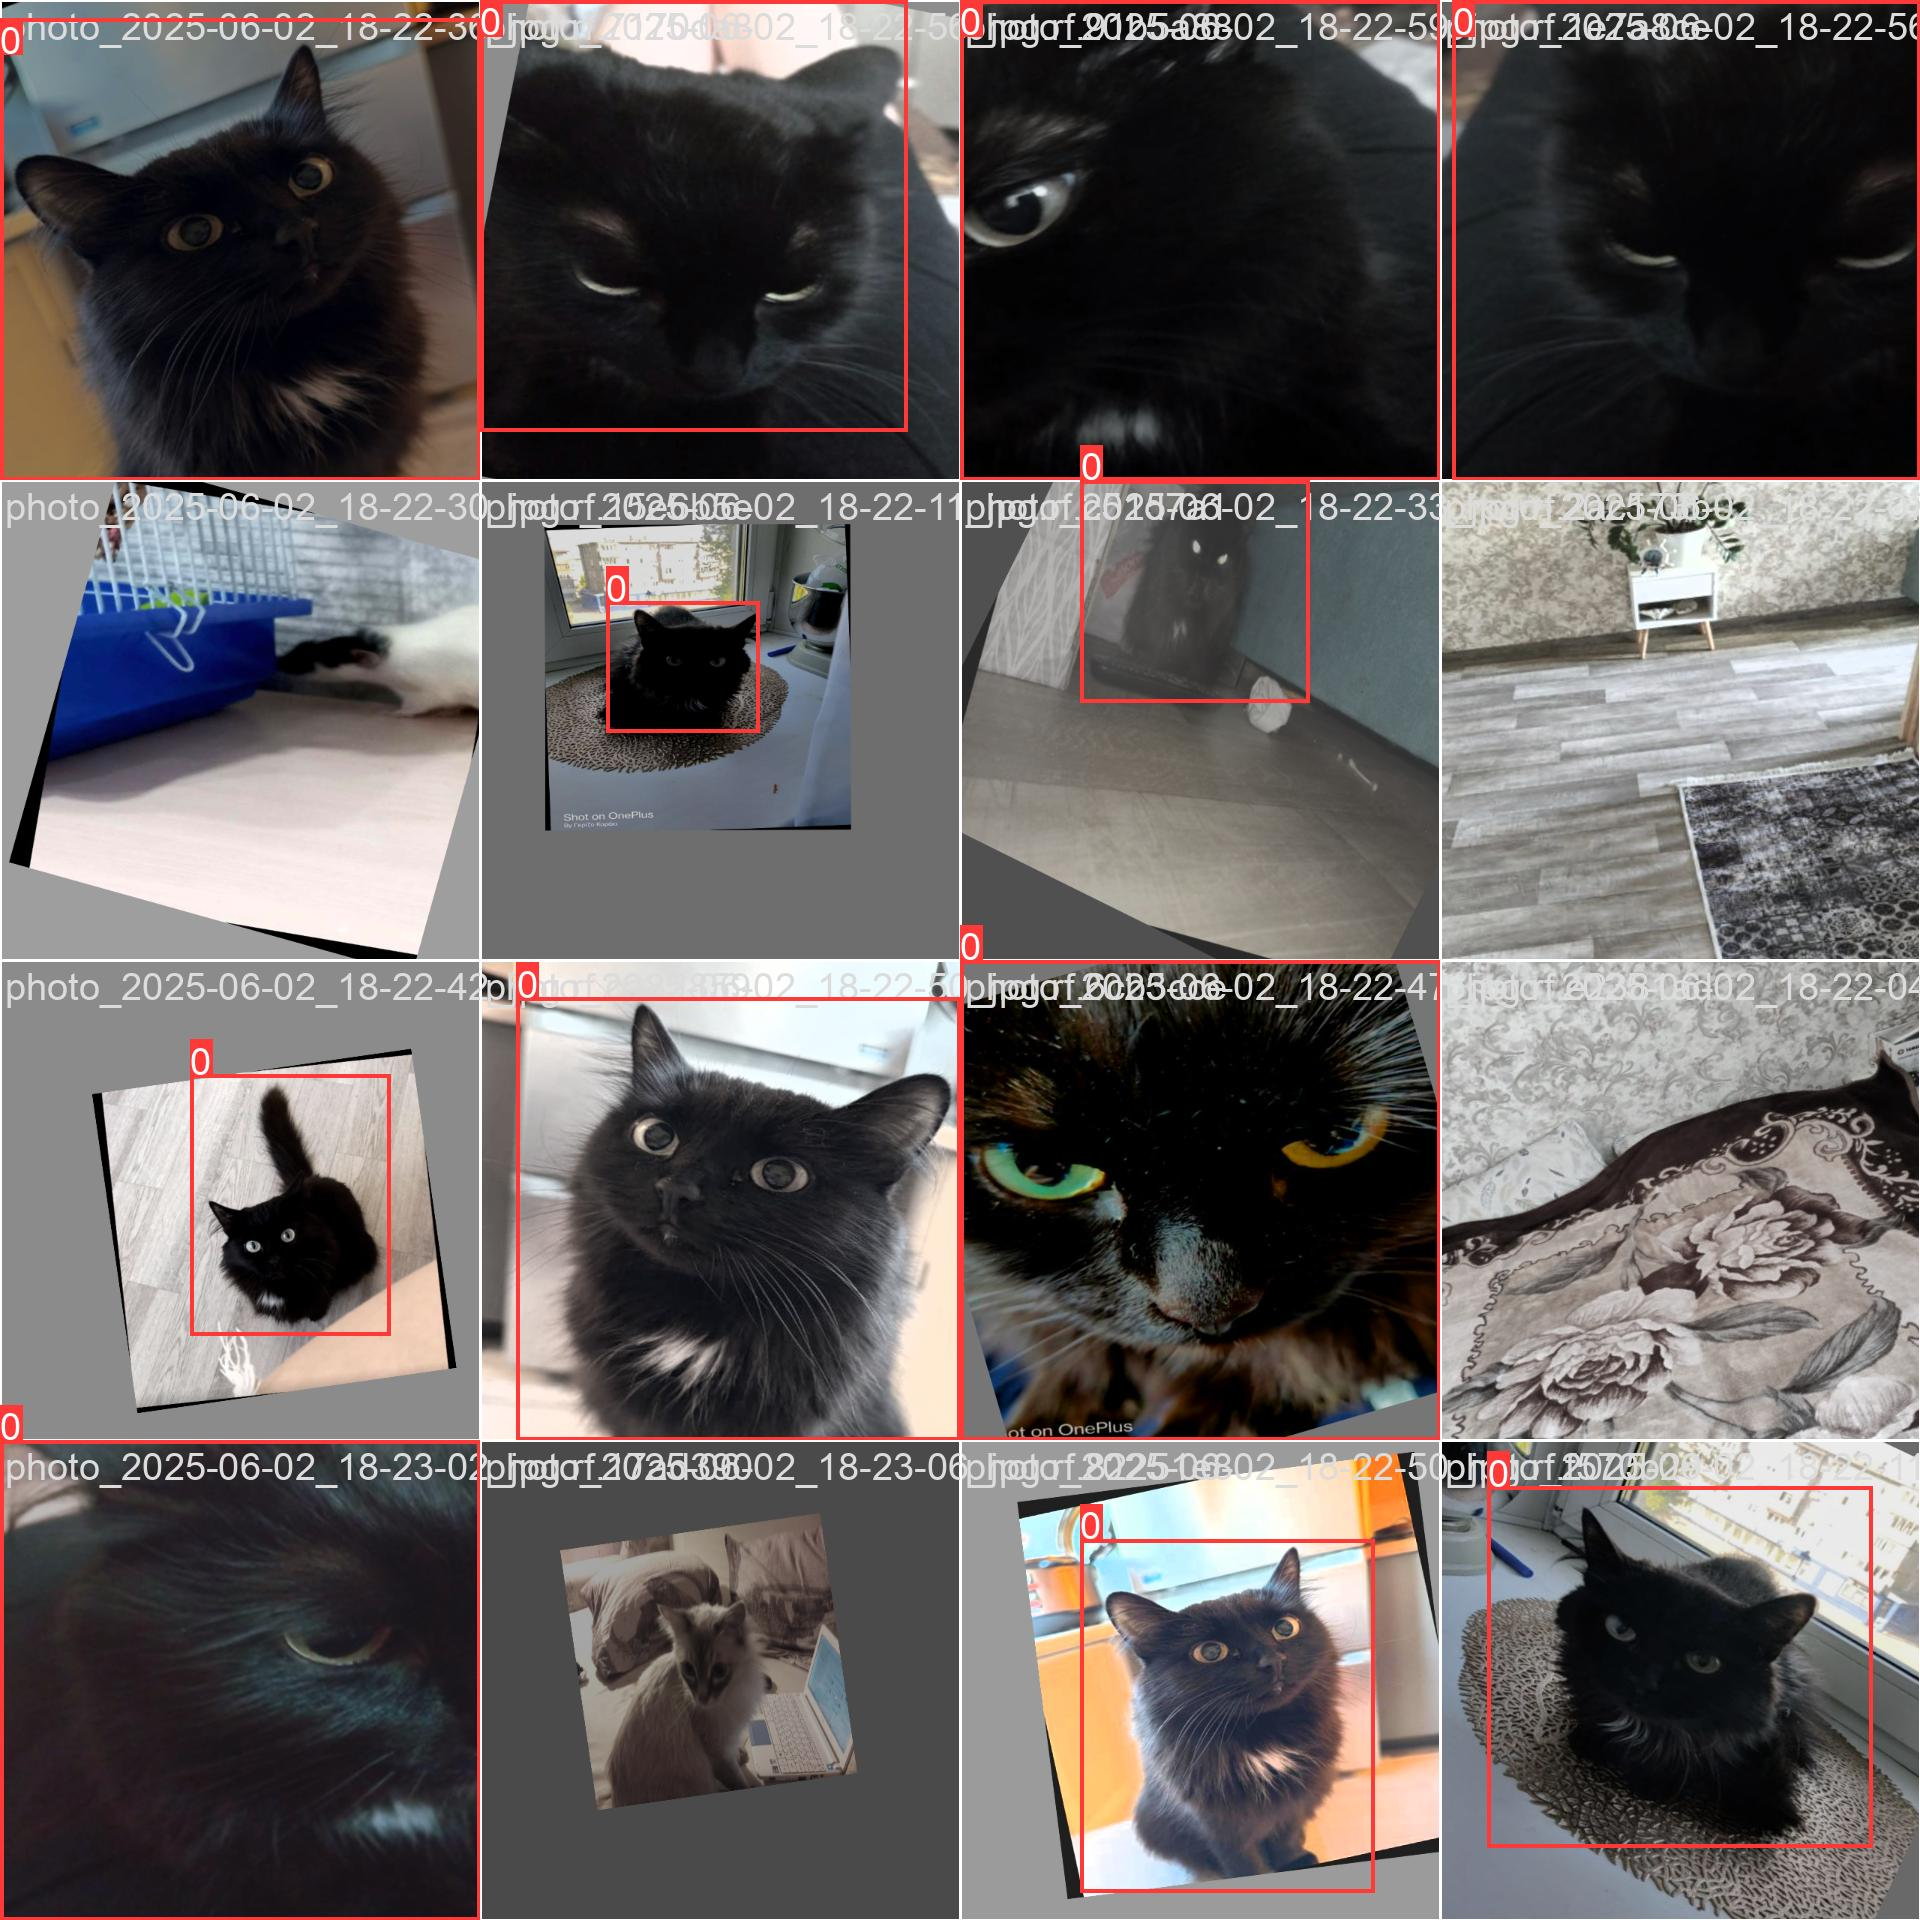

In [24]:
Display(filename='/content/My-Cat-Project-1/runs/detect/my_cat_model/train_batch162.jpg', width=1000)

### Используем transfer learning, замораживаем первые 10 слоев

In [11]:
model = YOLO("yolov8m.pt")

# Обучение на подготовленном датасете
results = model.train(
    data=f"{dataset.location}/data.yaml",
    freeze=10,
    epochs=50,
    imgsz=640,
    batch=16,
    name="my_cat_model_tl",
    pretrained=True,
    augment=True,  # Включаем аугментации пробно, так как данных категорически мало и есть немалая вероятность переобучения
    hsv_h=0.015,   # Изменение оттенка (hue) в диапазоне [0, 0.5]
    hsv_s=0.7,     # Изменение насыщенности (saturation) в диапазоне [0, 1]
    hsv_v=0.4,     # Изменение яркости (value) в диапазоне [0, 1]
    degrees=30.0,  # Максимальный угол поворота в градусах
    translate=0.1, # Перемещение (горизонтальное и вертикальное) в долях от размера изображения
    scale=0.5,     # Масштабирование в диапазоне [1-scale, 1+scale]
    shear=0.0,     # Скручивание (shear) в градусах, установлено 0 для простоты
    flipud=0.0,    # Вертикальное отражение (0.0 - отключено, 0.5 - 50% вероятность)
    fliplr=0.5,    # Горизонтальное отражение (0.5 - 50% вероятность)
    mosaic=1.0
)

New https://pypi.org/project/ultralytics/8.3.149 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.11.12 torch-2.5.1+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/My-Cat-Project-1/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=my_cat_model_tl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False,

### Сравниваем результаты

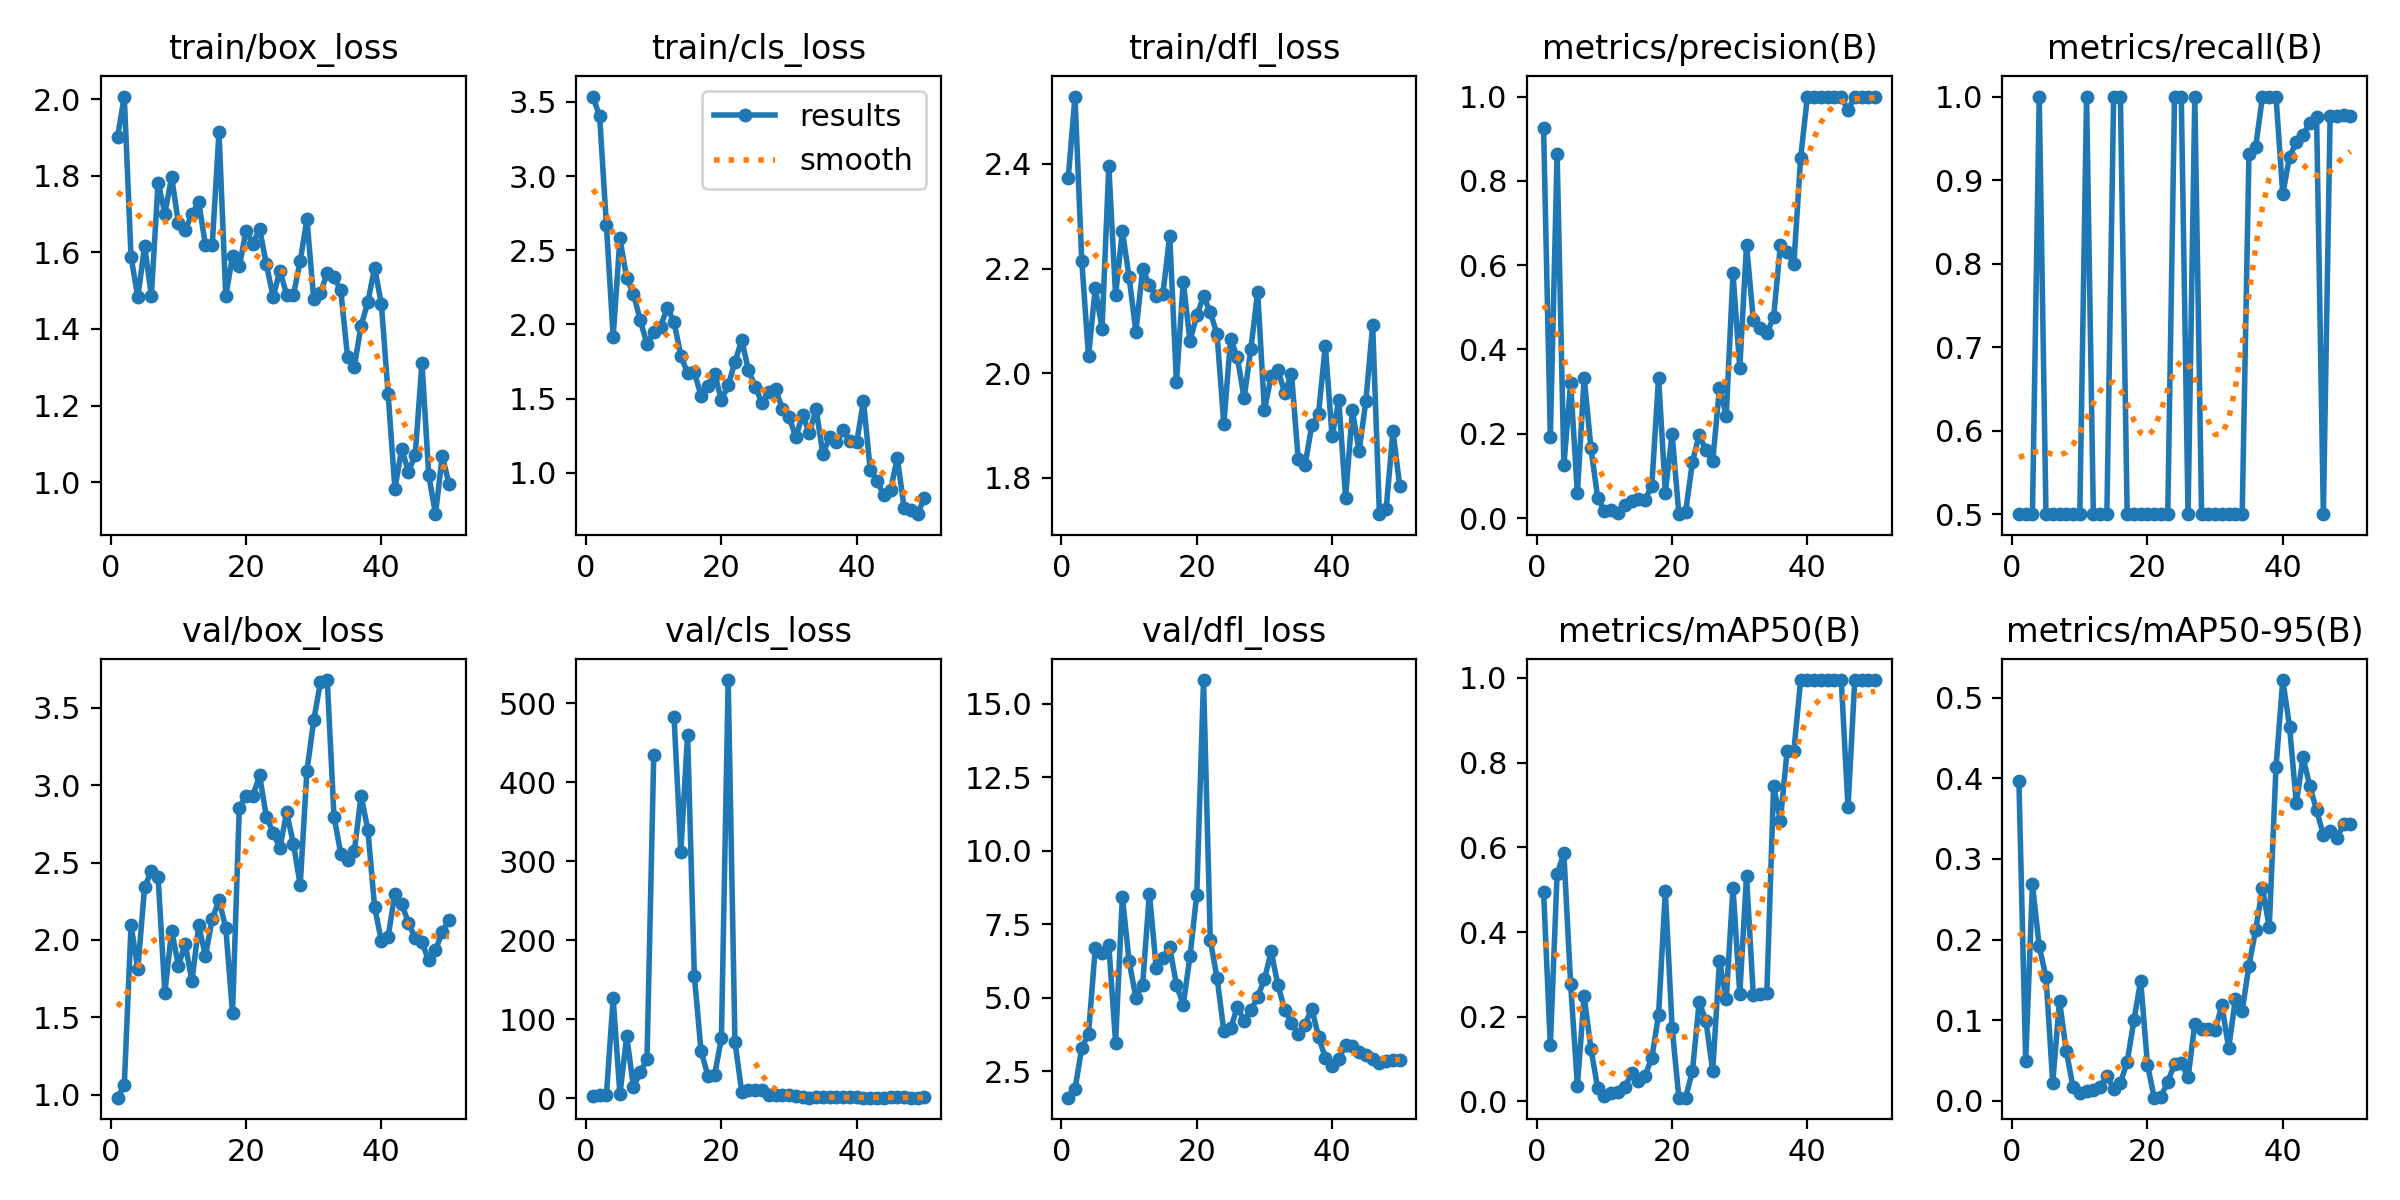

In [12]:
Display(filename='/content/My-Cat-Project-1/runs/detect/my_cat_model_tl/results.png', width=1080)

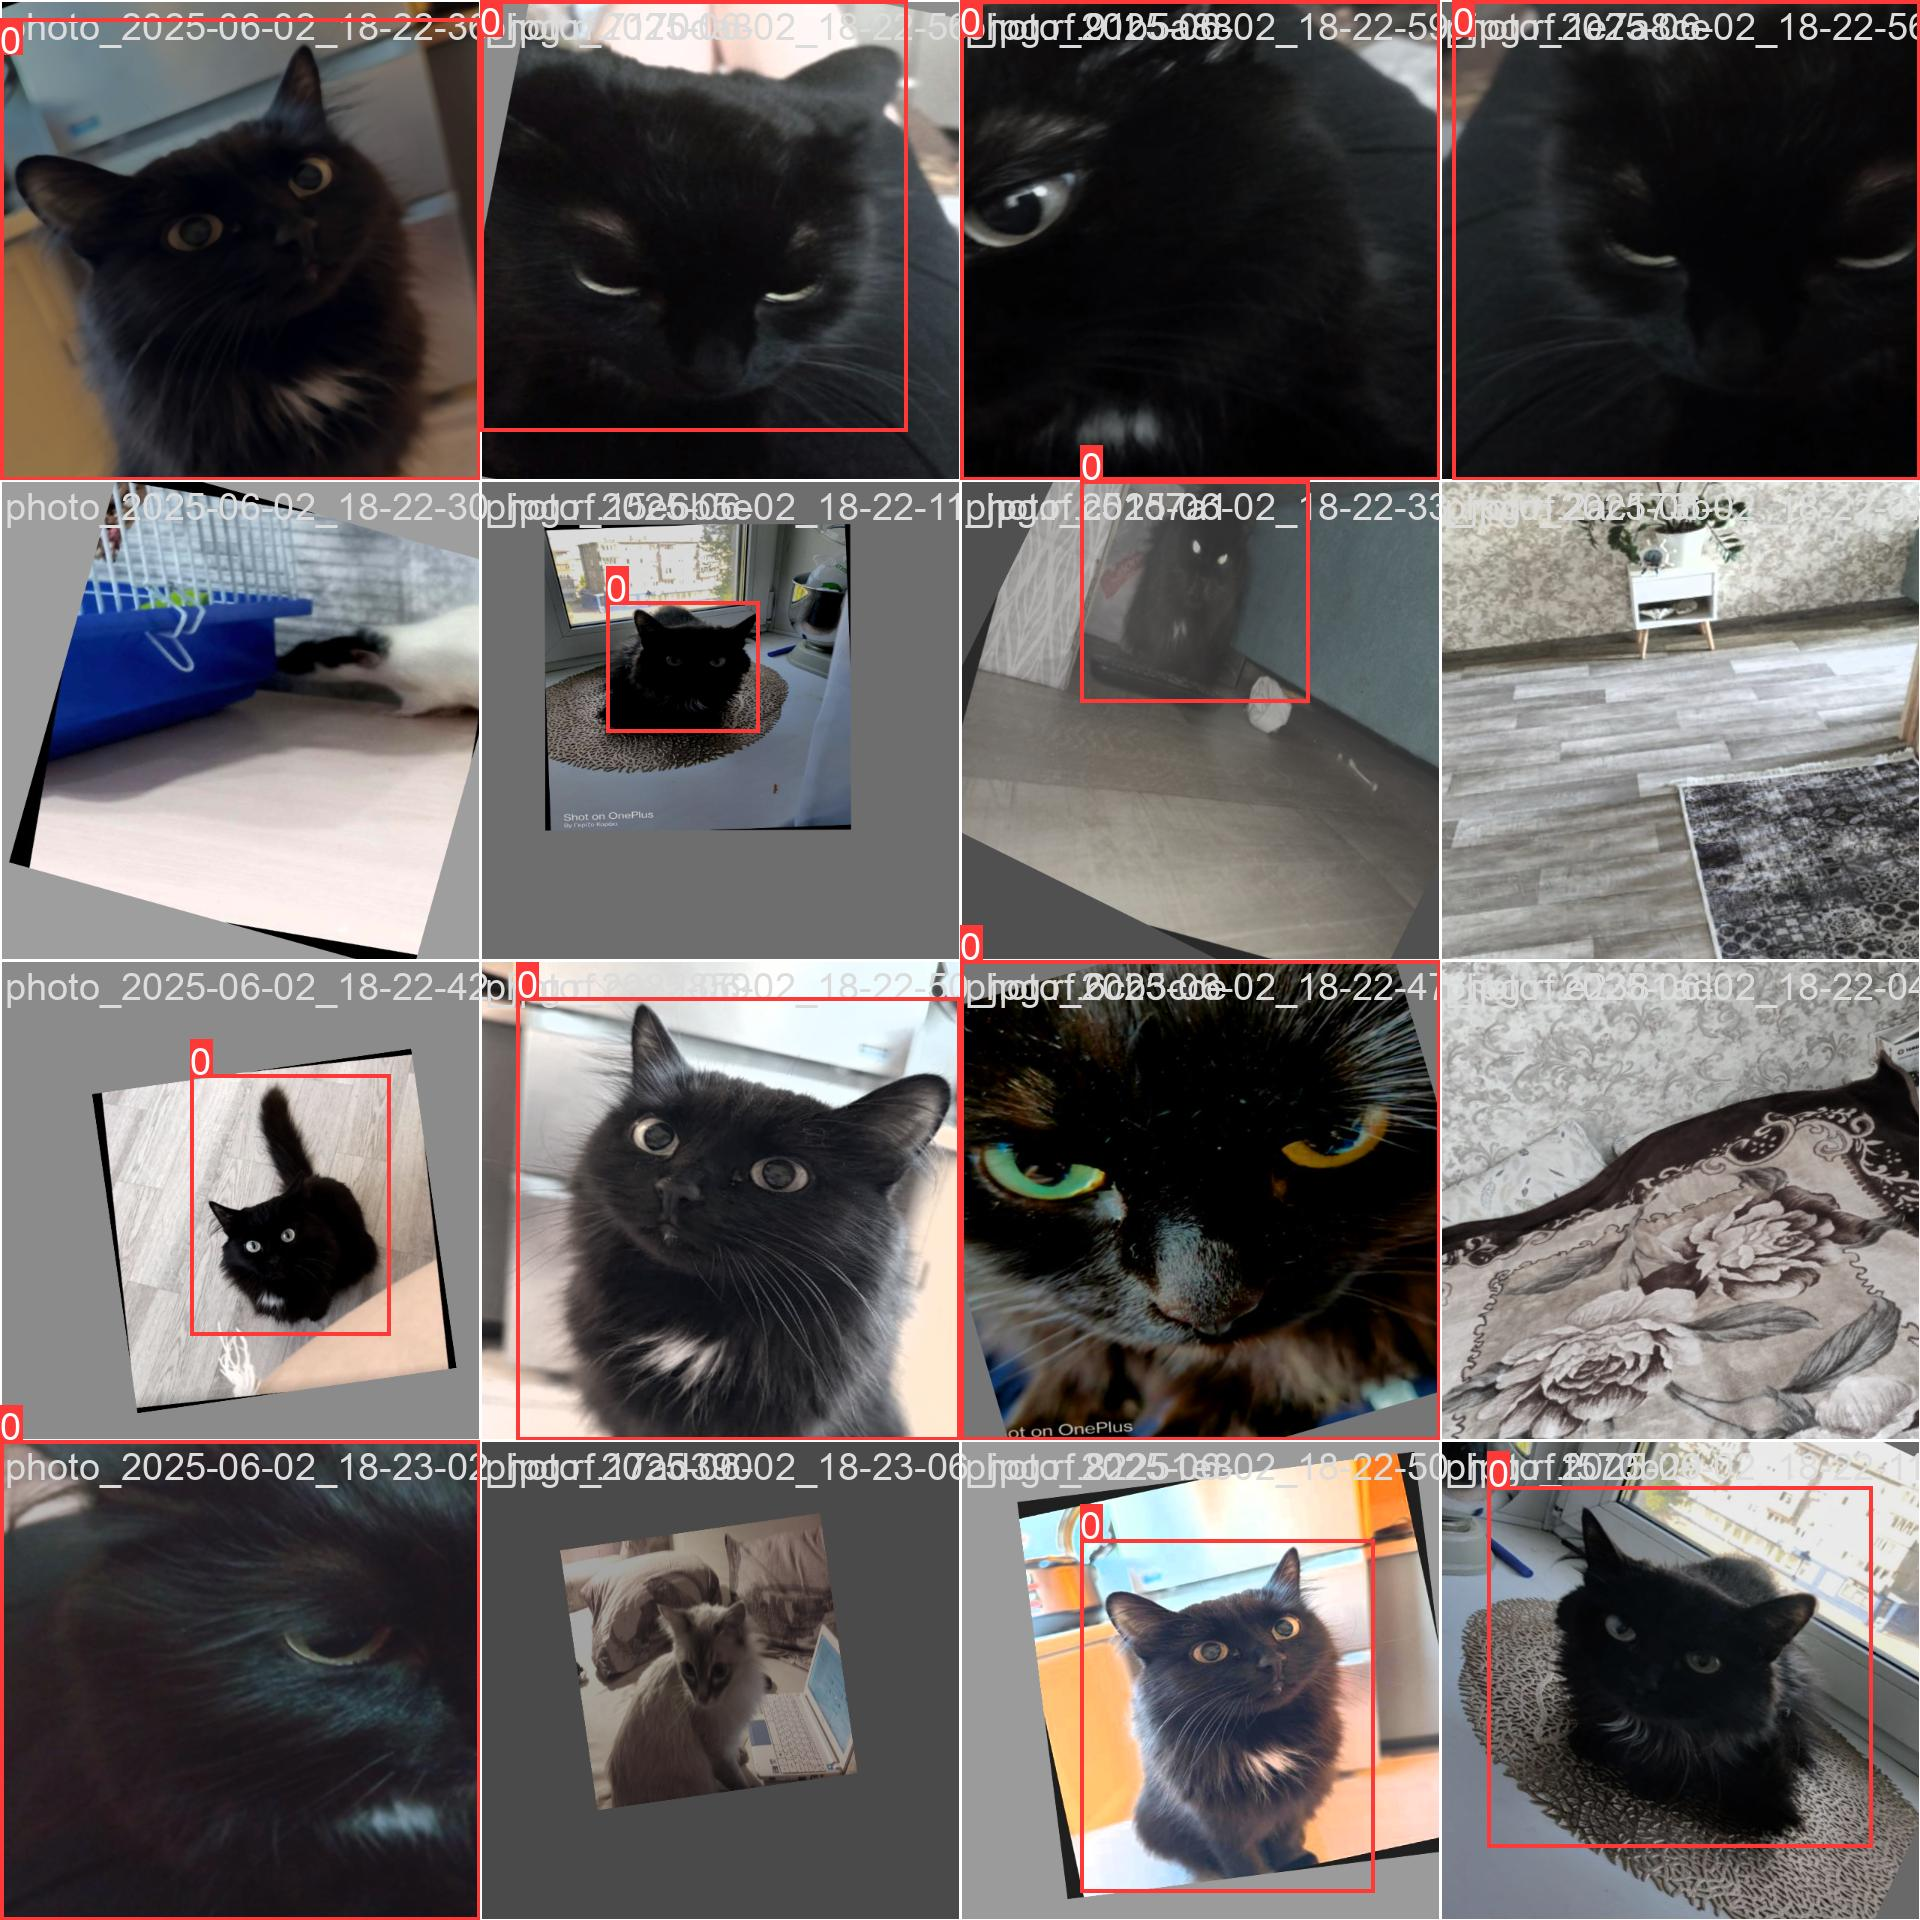

In [13]:
Display(filename='/content/My-Cat-Project-1/runs/detect/my_cat_model_tl/train_batch162.jpg', width=1000)

### Отображение результатов предсказания лучшей модели best.pt на примере загруженного изображения

In [14]:
!yolo detect predict model=/content/My-Cat-Project-1/runs/detect/my_cat_model_tl/weights/best.pt  conf=0.75 source=/content/prediction save = True

/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


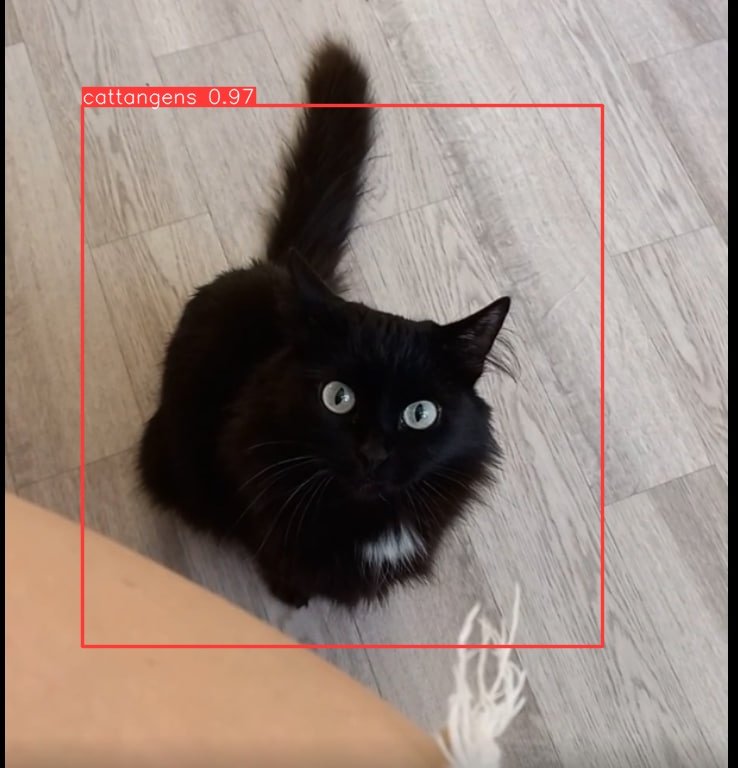

In [23]:
Display(filename='/content/My-Cat-Project-1/runs/detect/predict/photo_2025-06-02_18-22-42.jpg', width=800)

### 7. Веб сервис для работы с нейросетью из интерфейса браузера

In [ ]:
from flask import Flask, request, render_template, jsonify, send_file
from waitress import serve
from PIL import Image
import io

app = Flask(__name__)

# Путь к лучшей модели (локальный путь на Windows)
MODEL_PATH = "S:\code\vscode\Skillbox_Python_NeuralVision\PythonForInginiers\Module3\M3_hw7\MyCatDetection\models\best.pt"
model = YOLO(MODEL_PATH)

# Папки для загрузки и результатов
UPLOAD_FOLDER = 'uploads'
RESULT_FOLDER = 'results'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['RESULT_FOLDER'] = RESULT_FOLDER

# Уровень уверенности для детекции
CONFIDENCE_THRESHOLD = 0.75

# Главная страница
@app.route('/')
def index():
    # Очистка папок uploads и results при загрузке страницы
    for folder in [UPLOAD_FOLDER, RESULT_FOLDER]:
        if os.path.exists(folder):
            shutil.rmtree(folder)
        os.makedirs(folder, exist_ok=True)
    return render_template('index.html')

# Обработка загрузки изображения и детекции (JSON-ответ для фронтенда)
@app.route('/detect', methods=['POST'])
def detect_objects():
    try:
        if 'image_file' not in request.files:
            return jsonify({'error': 'No image file provided'}), 400
        file = request.files['image_file']
        if file.filename == '':
            return jsonify({'error': 'No selected file'}), 400

        # Сохранение загруженного файла
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], file.filename)
        file.save(file_path)

        # Выполнение детекции
        results = model.predict(source=file_path, conf=CONFIDENCE_THRESHOLD, save=False)

        # Форматирование результатов в bounding box'ы
        boxes = []
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                confidence = box.conf[0].item()
                class_id = int(box.cls[0].item()) if box.cls.numel() > 0 else 0
                boxes.append([x1, y1, x2, y2, confidence, class_id])

        # Рисование bounding box'ов на изображении для скачивания
        img = cv2.imread(file_path)
        for box in boxes:
            x1, y1, x2, y2, confidence, class_id = box
            label = f"Cat: {confidence:.2f}"
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Сохранение результата
        result_path = os.path.join(app.config['RESULT_FOLDER'], f"result_{file.filename}")
        cv2.imwrite(result_path, img)

        return jsonify(boxes)
    except Exception as e:
        return jsonify({'error': str(e)}), 500

# Возвращение обработанного изображения
@app.route('/get_result/<filename>')
def get_result(filename):
    result_path = os.path.join(app.config['RESULT_FOLDER'], f"result_{filename}")
    if os.path.exists(result_path):
        return send_file(result_path, mimetype='image/jpeg')
    return "Результат не найден", 404

if __name__ == '__main__':
    print("Запуск сервера на порту 8000...")
    serve(app, host='0.0.0.0', port=8000)

In [ ]:
# HTML файл index.html
"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Детекция кошки с YOLOv8</title>
    <script src="https://cdn.tailwindcss.com"></script>
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.4.0/css/all.min.css">
    <style>
        .dropzone {
            border: 2px dashed #94a3b8;
            transition: all 0.3s;
        }
        .dropzone-active {
            border-color: #4f46e5;
            background-color: #e0e7ff;
        }
        canvas {
            max-width: 100%;
            height: auto;
            border-radius: 0.5rem;
            box-shadow: 0 4px 6px -1px rgb(0 0 0 / 0.1), 0 2px 4px -2px rgb(0 0 0 / 0.1);
        }
        @keyframes spin {
            0% { transform: rotate(0deg); }
            100% { transform: rotate(360deg); }
        }
        .animate-spin-custom {
            animation: spin 1s linear infinite;
        }
    </style>
</head>
<body class="bg-gray-50 min-h-screen">
    <div class="container mx-auto px-4 py-8">
        <div class="text-center mb-8">
            <h1 class="text-3xl md:text-4xl font-bold text-gray-800 mb-2">Детекция кошки</h1>
            <p class="text-lg text-gray-600">Загрузите изображение для детекции моей кошки с YOLOv8</p>
        </div>
        <div class="max-w-3xl mx-auto bg-white rounded-xl shadow-md overflow-hidden p-6">
            <div id="uploadContainer" class="mb-6">
                <div id="dropzone" class="dropzone p-10 text-center rounded-lg cursor-pointer">
                    <div class="flex flex-col items-center justify-center space-y-3">
                        <i class="fas fa-cloud-upload-alt text-4xl text-indigo-500"></i>
                        <p class="text-gray-600">Перетащите изображение сюда или кликните для выбора</p>
                        <input id="uploadInput" type="file" class="hidden" accept="image/*" />
                        <button id="uploadBtn" class="bg-indigo-600 hover:bg-indigo-700 text-white font-medium py-2 px-4 rounded transition">
                            Выбрать изображение
                        </button>
                    </div>
                </div>
            </div>
            <div id="loadingSpinner" class="hidden flex justify-center items-center py-12">
                <div class="animate-spin-custom rounded-full h-12 w-12 border-t-2 border-b-2 border-indigo-500"></div>
                <span class="ml-3 text-gray-700">Обнаружение объектов...</span>
            </div>
            <div id="resultsContainer" class="hidden">
                <div class="flex justify-between items-center mb-4">
                    <h3 class="text-xl font-semibold text-gray-800">Результаты детекции</h3>
                    <div id="detectionStats" class="text-sm text-gray-500"></div>
                </div>
                <div class="relative">
                    <img id="detectionImage" class="mx-auto" style="max-width: 800px;">
                </div>
                <div id="objectList" class="mt-4 grid grid-cols-1 sm:grid-cols-2 md:grid-cols-3 gap-2"></div>
            </div>
            <div id="errorContainer" class="hidden p-4 mb-4 text-sm text-red-700 bg-red-100 rounded-lg">
                <i class="fas fa-exclamation-circle mr-2"></i>
                <span id="errorMessage"></span>
            </div>
        </div>
    </div>
    <script>
        const uploadInput = document.getElementById('uploadInput');
        const uploadBtn = document.getElementById('uploadBtn');
        const dropzone = document.getElementById('dropzone');
        const resultsContainer = document.getElementById('resultsContainer');
        const loadingSpinner = document.getElementById('loadingSpinner');
        const errorContainer = document.getElementById('errorContainer');
        const detectionImage = document.getElementById('detectionImage');
        const objectList = document.getElementById('objectList');
        const detectionStats = document.getElementById('detectionStats');

        uploadBtn.addEventListener('click', () => uploadInput.click());
        uploadInput.addEventListener('change', handleFileSelect);

        ['dragenter', 'dragover', 'dragleave', 'drop'].forEach(eventName => {
            dropzone.addEventListener(eventName, preventDefaults, false);
        });

        function preventDefaults(e) {
            e.preventDefault();
            e.stopPropagation();
        }

        ['dragenter', 'dragover'].forEach(eventName => {
            dropzone.addEventListener(eventName, highlight, false);
        });

        ['dragleave', 'drop'].forEach(eventName => {
            dropzone.addEventListener(eventName, unhighlight, false);
        });

        function highlight() {
            dropzone.classList.add('dropzone-active');
        }

        function unhighlight() {
            dropzone.classList.remove('dropzone-active');
        }

        dropzone.addEventListener('drop', handleDrop, false);

        function handleDrop(e) {
            const dt = e.dataTransfer;
            const file = dt.files[0];
            if (file && file.type.match('image.*')) {
                uploadInput.files = dt.files;
                handleFileSelect({ target: { files: [file] } });
            }
        }

        async function handleFileSelect(event) {
            const file = event.target.files[0];
            if (!file) return;

            if (!file.type.match('image.*')) {
                showError('Пожалуйста, выберите файл изображения (JPEG, PNG и т.д.)');
                return;
            }

            resultsContainer.classList.add('hidden');
            errorContainer.classList.add('hidden');
            loadingSpinner.classList.remove('hidden');

            try {
                const data = new FormData();
                data.append("image_file", file, "image_file");

                const response = await fetch("/detect", {
                    method: "POST",
                    body: data
                });

                if (!response.ok) {
                    throw new Error(`Ошибка сервера: ${response.status}`);
                }

                const detectionData = await response.json();

                if (detectionData.error) {
                    throw new Error(detectionData.error);
                }

                const resultResponse = await fetch(`/get_result/${file.filename}`);
                if (resultResponse.ok) {
                    const resultBlob = await resultResponse.blob();
                    detectionImage.src = URL.createObjectURL(resultBlob);
                }

                displayResults(file, detectionData);
            } catch (error) {
                console.error('Ошибка детекции:', error);
                showError('Не удалось обработать изображение: ' + error.message);
            } finally {
                loadingSpinner.classList.add('hidden');
            }
        }

        function displayResults(file, boxes) {
            const detectedObjects = {};
            boxes.forEach(box => {
                const [x1, y1, x2, y2, confidence, class_id] = box;
                const className = class_id === 0 ? 'Cat' : 'Unknown'; // Предполагаем, что class_id=0 для 'cat'

                detectedObjects[className] = (detectedObjects[className] || 0) + 1;
            });

            const totalObjects = boxes.length;
            detectionStats.textContent = `${totalObjects} объект${totalObjects !== 1 ? 'ов' : ''} обнаружено`;

            objectList.innerHTML = '';
            for (const [className, count] of Object.entries(detectedObjects)) {
                const item = document.createElement('div');
                item.className = 'bg-gray-100 px-3 py-2 rounded flex items-center justify-between';
                item.innerHTML = `
                    <span class="font-medium">${className}</span>
                    <span class="bg-indigo-100 text-indigo-800 text-xs px-2 py-1 rounded-full">${count}</span>
                `;
                objectList.appendChild(item);
            }

            resultsContainer.classList.remove('hidden');
        }

        function showError(message) {
            errorContainer.classList.remove('hidden');
            document.getElementById('errorMessage').textContent = message;
        }
    </script>
</body>
</html>


"""

### 8. Выводы по практической работе